---

# 3 Finding Best Routes (Q3)
Whenever you plan to fly to a specific city, your goal is to find the most efficient and fastest flight to reach your destination. In the system you are designing, the best route is defined as the one that minimizes the total distance flown to the greatest extent possible.
> In this task, you need to implement a function that, given an origin and destination city, determines the best possible route between them. To simplify, the focus will be limited to flights operating on a specific day.

Note: Each city may have multiple airports; in such cases, the function should calculate the best route for every possible airport pair between the two cities. For example, if city A has airports a1, a2, and city B has b1, b2, the function should compute the best routes for a1 → b1, a1 → b2, a2 → b1 and a2 → b2. If it's not possible to travel from one airport in the origin city to another airport in the destination city on that date, you must report it as well.

The function takes the following inputs:
1. Flights network
2. Origin city name
3. Destination city name
4. Considered Date (in yyyy-mm-dd format)

The function output:
1. A table with three columns: 'Origin _city_airport, 'Destination_city_airport', and the 'Best_route.

Note: In the "Best _route" column, we expect a list of airport names connected by →, showing the order in which they are to be visited during the optimal route. If no such route exists, the entry should display "No route found."

---

In [1]:
import modules.shortest_path
import pandas as pd
import numpy as np
df = pd.read_csv('Airports2.csv')
df = df.drop_duplicates(keep='last') # Drop duplicates, keeping the last entry

Having loaded the data and removed duplicate entries by keeping the last entries only, we can proceed with selecting only the relevant columns for the task of Question 3. Namely by selecting by only keeping the columns 'Origin_airport', 'Destination_airport', 'Fly_date', 'Origin_city', 'Destination_city', 'Distance' and making a new dataframe, **working_df**.

In [ ]:
df.head()

Origin_airport Destination_airport    Origin_city Destination_city  \
0            MHK                 AMW  Manhattan, KS         Ames, IA   
1            EUG                 RDM     Eugene, OR         Bend, OR   
2            EUG                 RDM     Eugene, OR         Bend, OR   
3            EUG                 RDM     Eugene, OR         Bend, OR   
4            MFR                 RDM    Medford, OR         Bend, OR   

   Passengers  Seats  Flights  Distance    Fly_date  Origin_population  \
0          21     30        1       254  2008-10-01             122049   
1          41    396       22       103  1990-11-01             284093   
2          88    342       19       103  1990-12-01             284093   
3          11     72        4       103  1990-10-01             284093   
4           0     18        1       156  1990-02-01             147300   

   Destination_population  Org_airport_lat  Org_airport_long  \
0                   86219        39.140999        -96.670799   
1                   76034        44.124599       -123.211998   
2                   76034        44.124599       -123.211998   
3                   76034        44.124599       -123.211998   
4                   76034        42.374199       -122.873001   

   Dest_airport_lat  Dest_airport_long  
0               NaN                NaN  
1         44.254101        -121.150002  
2         44.254101        -121.150002  
3         44.254101        -121.150002  
4         44.254101        -121.150002

In [3]:
# I only need origin_airport, destination_airport, fly_date, origin_city, destination_city, and distance
working_df = df[['Origin_airport', 'Destination_airport', 'Fly_date', 'Origin_city', 'Destination_city', 'Distance']].copy()

Performing some sanity checks below:

In [4]:
working_df.isna().sum()

Origin_airport         0
Destination_airport    0
Fly_date               0
Origin_city            0
Destination_city       0
Distance               0
dtype: int64

In [5]:
working_df.dtypes

Origin_airport         object
Destination_airport    object
Fly_date               object
Origin_city            object
Destination_city       object
Distance                int64
dtype: object

In [6]:
print(f"Any empty values in 'Origin_airport' column: {sum(working_df.Origin_airport == "")}") # check if there are empty strings in Origin_airport
print(f"Any empty values in 'Destination_airport' column: {sum(working_df.Destination_airport == "")}") # check if there are empty strings in Destination_airport
print(f"Any empty values in 'Fly_date' column: {sum(working_df.Fly_date == "")}") # check if there are empty strings in Fly_date
print(f"Any empty values in 'Origin_city' column: {sum(working_df.Origin_city == "")}") # check if there are empty strings in Origin_city
print(f"Any empty values in 'Destination_city' column: {sum(working_df.Destination_city == "")}") # check if there are empty strings in Destination_city
print(f"Any NA value in 'Distance' column: {working_df.Distance.isna().sum()}") # check if there are empty strings in Distance

Any empty values in 'Origin_airport' column: 0
Any empty values in 'Destination_airport' column: 0
Any empty values in 'Fly_date' column: 0
Any empty values in 'Origin_city' column: 0
Any empty values in 'Destination_city' column: 0
Any NA value in 'Distance' column: 0


In [7]:
working_df.Origin_airport = working_df.Origin_airport.str.strip()
working_df.Destination_airport = working_df.Destination_airport.str.strip()
working_df.Fly_date = working_df.Fly_date.str.strip()
working_df.Origin_city = working_df.Origin_city.str.strip()
working_df.Destination_city = working_df.Destination_city.str.strip()

Because the algorithm we will use to find the shortest path in terms of distances requires non negative weights (distances), referring to Dijkstra's Algorithm, we have to ensure that no distance in the dataframe is negative and if, a few of them are negative, perhaps due to errors, we will remove those records.

In [8]:
working_df.Distance = working_df.Distance.astype(int)
print(f"Is there any record of flight with negative distance? Answer: {'Yes' if np.any(working_df.Distance < 0) else 'No'}")

Is there any record of flight with negative distance? Answer: No


We will now proceed to convert our dataframe to a __network__ of flights by making use of NetworkX data structure. We will create a flight network, using the `create_flight_network` defined in __shortest_path__ module, that takes in a dataframe and returns a Directed Graph (based on NetworkX data structure) along with relevant nodes, edges, and *data*.

In [9]:
help(shortest_path.create_flight_network)
flight_network = shortest_path.create_flight_network(working_df)

Help on function create_flight_network in module shortest_path:

create_flight_network(working_df)
    Input:
    working_df: pd.DataFrame, the working dataframe

    Output:
    G: nx.DiGraph, the flight network

    About:
    This function creates a directed graph using the networkx library.
    The nodes of the graph are the airports and the edges are the flights between the airports.
    The graph has the following attributes:
    - Node attributes: city
    - Edge attributes: distance, date



100%|██████████| 3565050/3565050 [00:05<00:00, 648854.65it/s]


Having prepared the flight network, we can get a brief look at the problem we are trying to solve: <br>

__Generic Problem__: Single-Source Shortest Paths.

__Input__: A directed graph $G = (V, E)$, a starting vertex $s \in V$, and a nonnegative length $l_e$ for each edge $e \in E$. <br>
__Output__: $dist(s,v)$ for every vertex $v \in V$. <br> <br>

---

<h4 style="text-align:center;">Pseudocode for the Algorithm Deployed: <i>(deploy_dijkstra in the shortest_path module)</i></h4>

$$Dijkstra's Algorithm$$

**Input:**
- A graph $ G = (V, E) $ in adjacency-list form. Each edge $ e = (u, v) $ must have a non-negative weight $ l_{u,v} $.
- A source node $ s \in V $.

**Output:**
- `distances[v]`: The shortest distance from $ s $ to every node $ v $.
- `predecessors[v]`: The predecessor of $ v $ in the shortest path, which we will use for path reconstruction.


__Steps:__

1. **Initialization:**
    > Create a `distances` dictionary: <br>
     - distances[v] = $+\infty$ for all $ v \in V $ (because we don't know the shortest distance).<br>
     - distances[s] = 0 (distance to the source is zero).<br>
    > Create a `predecessors` dictionary:<br>
     - predecessors[v] = None, for all $ v \in V $ (initially, we don't know the path leading to each V so we equate each to None).<br>
    > Create a `priority_queue` (min-heap) and insert $(0, s)$, where first value in the tuple is the initialised distance and second value in the name of the Node. *The queue ensures that the node with the smallest known distance is processed first.*<br>

2. **Main Loop:** <br>
    While `priority_queue` is not empty: <br>
    > Extract the node with the smallest distance by popping the first tuple from the queue: `current_distance, current_node = heapq.heappop(priority_queue)`. <br>
    > If `current_distance > distances[current_node]`, skip this node (stale entry). <br>
    > For each neighbor $ v $ of `current_node`:<br>
       - Retrieve the edge weight (distance): $ l_{current\_node, v} $.<br>
       - Compute the *tentative* distance:<br>
         - `new_distance = current_distance + l_{current_node, v}`.<br>
       - If `new_distance < distances[v]`:<br>
         - Update `distances[v] = new_distance`.<br>
         - Update `predecessors[v] = current_node` so that we get a record of what preceeded the node in ordering of distance.<br>
         - Push `(new_distance, v)` into the `priority_queue` so that we can iteratively start from the next node with the smallest distance.<br>

3. **Returns:**
   - `distances`: The shortest distance from $ s $ to every reachable node.
   - `predecessors`: The predecessor of each node for path reconstruction.

__Postcondition__: for every vertex $v$, the value $len(v)$ equals the true shortest-path distance $dist(s, v)$.

---

In the the __shortest_path__ module, we have created a function `deploy_dijkstra` using the pseudocode outlined about. It takes a flight network and a source airport code as input, and returns the shortest paths from the source airport to all other airports in the network using Dijkstra's algorithm. For more information, please refer to the docstring of the function using the following command: `help(shortest_path.deploy_dijkstra)` or navigate to the __shortest_path__ module and check the docstring of the function. <br>

In [10]:
print(f"Printing the Docstring of the function deploy_dijkstra for reference:")
help(shortest_path.deploy_dijkstra)

Printing the Docstring of the function deploy_dijkstra for reference:
Help on function deploy_dijkstra in module shortest_path:

deploy_dijkstra(flight_network, source)
    Input:
    flight_network: nx.DiGraph
    source: str, the origin airport code

    Output:
    shortest_paths: dict, key: destination airport code, value: shortest path from source to destination
    predecessors: dict, key: destination airport code, value: predecessor of the destination airport

    About:
    This function computes the shortest paths from a source airport to all other airports in the network using Dijkstra's algorithm.



Recalling that the questions requires us to take find the shortest paths between airports from an origin city to airports in a destination city considering a __specific date__, we have created a fucntion named as `get_graph_for_a_date`which takes as inputs a date (str) and a directed graph, and returns back a directed graph but with nodes and edges which have the date attribute equal to the inserted into the function. This function will serve as a helper function for the next function `get_shortest_paths_for_a_date` which we will describe shortly. For more information on `get_graph_for_a_date`, please refer to the docstring of the function using the following command: `help(shortest_path.get_graph_for_a_date)` or navigate to the __shortest_path__ module and check the docstring of the function. <br>

In [11]:
print(f"Printing the Docstring of the function get_graph_for_a_date for reference:")
help(shortest_path.get_graph_for_a_date)

Printing the Docstring of the function get_graph_for_a_date for reference:
Help on function get_graph_for_a_date in module shortest_path:

get_graph_for_a_date(G, date)
    Inputs:
    G: (nx.DiGraph): Original graph.
    date: (str): Date to filter edges.

    Output:
    graph_for_a_date: (nx.DiGraph): Filtered graph.

    About:
    Filters the graph to include only flights available on the given date.



We have defined our Dijkstra's algorithm in a way that it also returns a dictionary of __predecessors__, which is a mapping of each node to its predecessor. This dictionary will be used to reconstruct the shortest path from the source to the destination. Here is where the __helper function__ `reconstruct_path` comes into play. It takes as inputs the predecessors dictionary, the source node, and the destination node, and returns the shortest path as a list of nodes. For more information on `reconstruct_path`, please refer to the docstring of the function using the following command: `help(shortest_path.reconstruct_path)` or navigate to the __shortest_path__ module and check the docstring of the function. <br>

In [12]:
print(f"Printing the Docstring of the function reconstruct_path for reference:")
help(shortest_path.reconstruct_path)

Printing the Docstring of the function reconstruct_path for reference:
Help on function reconstruct_path in module shortest_path:

reconstruct_path(predecessors, source, destination)
    Inputs:
    - predecessors (dict): Mapping of each node to its predecessor.
    - source (str): The source node.
    - destination (str): The destination node.

    Output:
    path: (list): List of nodes representing the shortest path.

    About:
    Reconstructs the shortest path from source to destination.



Finally, we can move on to the main function `get_shortest_paths_for_a_date`. This function takes as inputs a date (str), a source city (str), a destination city (str), and a directed graph, and returns the shortest paths, in form of a __table__, from all the airports in the source city to all airports in the destination city on the given date. The function uses the helper functions `get_graph_for_a_date`, `deploy_dijkstra`, and `reconstruct_path` to achieve this. For more information on `get_shortest_paths_for_a_date`, please refer to the docstring of the function using the following command: `help(shortest_path.get_shortest_paths_for_a_date)` or navigate to the __shortest_path__ module and check the docstring of the function.

In [13]:
print(f"Printing the Docstring of the function get_shortest_paths_for_a_date for reference:")
help(shortest_path.get_shortest_paths_for_a_date)

Printing the Docstring of the function get_shortest_paths_for_a_date for reference:
Help on function get_shortest_paths_for_a_date in module shortest_path:

get_shortest_paths_for_a_date(flight_network, origin_city_name, destination_city_name, date)
    Inputs:
    flight_network: nx.DiGraph, the flight network
    origin_city_name: str, the name of the origin city
    destination_city_name: str, the name of the destination city
    date: str, the date of the flight

    Output:
    df: pd.DataFrame, the table with the best routes

    About:
    This function computes the best routes between all possible airport pairs between the origin and destination cities on a given date.



In [10]:
origin_city = "New York, NY"
destination_city = "Los Angeles, CA"
date = "2009-09-01"
shortest_paths = shortest_path.get_shortest_paths_for_a_date(flight_network, origin_city, destination_city, date)

In [11]:
print(f"The following table prints the best routes from a particular airport in a specific origin city to a particular airport in a specific destination city on a particular date: {date}")
shortest_paths

The following table prints the best routes from a particular airport in a specific origin city to a particular airport in a specific destination city on a particular date: 2009-09-01


Origin_city_airport Destination_city_airport                    Best_route  \
0                 JFK                      LAX       JFK->MKC->MCI->ELP->LAX   
1                 LGA                      LAX       LGA->RFD->DFW->ELP->LAX   
2                 JRA                      LAX                No route found   
3                 JRB                      LAX  JRB->JFK->MKC->MCI->ELP->LAX   
4                 TSS                      LAX                No route found   
5                 WTC                      LAX                No route found   

   Total_distance  
0          2672.0  
1          2835.0  
2             NaN  
3          2685.0  
4             NaN  
5             NaN

Even though it was not requested, we also added total_distance from origin airport to the destination airport for comparisons. To confirm if our results are correct, we thought of checking about the possibility that the there is an edge (a flight) from an airport in New York to an airport in Los Angeles (only LAX) because both cities are rather infamous. If there is an edge, then obviously that should be the shortest path between the two airports (instead of taking multiple connecting flights)

In [12]:
# Get the filtered flight network for the specific date
flight_network_filtered = shortest_path.get_graph_for_a_date(flight_network, date)

# Get airports for New York City
airports_for_nyc = [airport_code for airport_code, data in flight_network_filtered.nodes(data=True) if data['city'] == 'New York, NY']
print(f"Airports for New York City: {airports_for_nyc}")

# Get airports for Los Angeles
airports_for_la = [airport_code for airport_code, data in flight_network_filtered.nodes(data=True) if data['city'] == 'Los Angeles, CA']
print(f"Airports for Los Angeles: {airports_for_la}")

# Check for flights from New York City to Los Angeles
for airport_code in airports_for_nyc:
    if flight_network_filtered.has_edge(airport_code, airports_for_la[0]):
        print(f"Flight from New York City to Los Angeles on {date} is available from airport {airport_code}")
        # Print the distances
        print(f"Distance: {flight_network_filtered[airport_code][airports_for_la[0]]['distance']} miles")
    else:
        print(f"No flight available from New York City to Los Angeles, on {date} from airport {airport_code} to {airports_for_la}. For this reason, no distance available")

Airports for New York City: ['JFK', 'LGA', 'JRA', 'JRB', 'TSS', 'WTC']
Airports for Los Angeles: ['LAX']
No flight available from New York City to Los Angeles, on 2009-09-01 from airport JFK to ['LAX']. For this reason, no distance available
No flight available from New York City to Los Angeles, on 2009-09-01 from airport LGA to ['LAX']. For this reason, no distance available
No flight available from New York City to Los Angeles, on 2009-09-01 from airport JRA to ['LAX']. For this reason, no distance available
No flight available from New York City to Los Angeles, on 2009-09-01 from airport JRB to ['LAX']. For this reason, no distance available
No flight available from New York City to Los Angeles, on 2009-09-01 from airport TSS to ['LAX']. For this reason, no distance available
No flight available from New York City to Los Angeles, on 2009-09-01 from airport WTC to ['LAX']. For this reason, no distance available


The output above shows that there was no direct flight from NYC to LA - thus solidying the correctness of our results.

---

**Another check**

Using the original flight network (not filtered by date) to check for flights from New York City to Los Angeles so that we can get the date of the flight

In [13]:
airports_for_nyc = [airport_code for airport_code, data in flight_network.nodes(data=True) if data['city'] == 'New York, NY']
print(f"Airports for New York City: {airports_for_nyc}")

# Get airports for Los Angeles
airports_for_la = [airport_code for airport_code, data in flight_network.nodes(data=True) if data['city'] == 'Los Angeles, CA']
print(f"Airports for Los Angeles: {airports_for_la}")

# Check for flights from New York City to Los Angeles
for airport_code in airports_for_nyc:
    if flight_network.has_edge(airport_code, airports_for_la[0]):
        print(f"Flight from New York City to Los Angeles on {flight_network[airport_code][airports_for_la[0]]['date']} is available from airport {airport_code}")
        # Print the distances
        print(f"Distance: {flight_network[airport_code][airports_for_la[0]]['distance']} miles")
    else:
        print(f"No flight available from New York City to Los Angeles, on {date} from airport {airport_code} to {airports_for_la[0]}. For this reason, no distance available")

Airports for New York City: ['JFK', 'LGA', 'JRA', 'JRB', 'TSS', 'WTC']
Airports for Los Angeles: ['LAX']
Flight from New York City to Los Angeles on 2009-12-01 is available from airport JFK
Distance: 2475 miles
Flight from New York City to Los Angeles on 2009-10-01 is available from airport LGA
Distance: 2469 miles
No flight available from New York City to Los Angeles, on 2009-09-01 from airport JRA to LAX. For this reason, no distance available
No flight available from New York City to Los Angeles, on 2009-09-01 from airport JRB to LAX. For this reason, no distance available
No flight available from New York City to Los Angeles, on 2009-09-01 from airport TSS to LAX. For this reason, no distance available
No flight available from New York City to Los Angeles, on 2009-09-01 from airport WTC to LAX. For this reason, no distance available


In [14]:
date = '2009-12-01'
shortest_paths = shortest_path.get_shortest_paths_for_a_date(flight_network, origin_city, destination_city, date)

print(f"The following table prints the best routes from a particular airport in a specific origin city to a particular airport in a specific destination city on a particular date")

shortest_paths

The following table prints the best routes from a particular airport in a specific origin city to a particular airport in a specific destination city on a particular date


Origin_city_airport Destination_city_airport      Best_route  Total_distance
0                 JFK                      LAX        JFK->LAX          2475.0
1                 LGA                      LAX   LGA->ORD->LAX          2478.0
2                 JRA                      LAX  No route found             NaN
3                 JRB                      LAX  No route found             NaN
4                 TSS                      LAX  No route found             NaN
5                 WTC                      LAX  No route found             NaN

The output above shows matches the true minimum intuitive distance!

---

# Q4 - Airline Network Partitioning 
Imagine all these flights are currently managed by a single airline. However, this airline is facing bankruptcy and plans to transfer the management of part of its operations to a different airline. The airline is willing to divide the flight network into two distinct partitions, $P_1$ and $P_2$, such that no flights connect any airport in $P_1$, to any airport in $P_2$. The flights in $P_1$, will remain under the management of the original airline, while those in $P_2$, will be handed over to the second airline. Any remaining flights needed to connect these two partitions will be determined later.

In graph theory, this task is known as a graph disconnection problem. Your goal is to write a function that removes the minimum number of flights between airports to separate the original flight network into two disconnected subgraphs.

The function takes the following inputs:
- Flight network


The function outputs:
- The flights removed to disconnect the graph.
- Visualize the original flight network.
- Visualize the graph after removing the connections and highlight the two resulting subgraphs.

Note: In this task, airline only concerned with the flights between airports, and the flight times are not relevant.

---

For the problem of graph disconnection, several algorithms can be used to determine the minimum number of edges, or in our case, flights, that need to be removed to divide the flight network into two distinct disconnected components. This problem is a variation of the min-cut problem, which is informally defined as: <br>

**Input**: An undirected and unweighted graph ${\displaystyle G=(V,E)}$ <br>
**Output**: Compute a cut with the fewest number of edges that separates the graph into two disconnected components. <br>

This problem can be addressed using algorithms such as:

- **Maximum Flow / Minimum Cut Theorem** (using Edmonds-Karp algorithm)
- **Stoer-Wagner Minimum Cut Algorithm**
- **Randomized Min-Cut Algorithm** (using Karger’s Algorithm)

We will be using the **Stoer-Wagner Minimum Cut Algorithm** to approach the problem outlined above. Before proceeding about how it works, let’s define some important terms:

1. **Cuts of a Graph**: A **cut** of a graph ${\displaystyle G=(V,E)}$ is a partition of $V$ (the set of vertices) into two **non-empty** sets, **A** and **B**. The **cut-set** is the set of edges whose removal would disconnect the graph into two separate components. <br>

2. __Edge Contraction__: This operation takes two connected nodes, merges them into a single node, and removes any self-loops that are created as a result of the contraction. In more detail, The result of contracting the edge ${\displaystyle e=\{u,v\}}$ is a new node ${\displaystyle uv}$. Every edge ${\displaystyle \{w,u\}}$ or ${\displaystyle \{w,v\}}$ for ${\displaystyle w\notin \{u,v\}}$ to the endpoints of the contracted edge is replaced by an edge ${\displaystyle \{w,uv\}}$ to the new node. Finally, the contracted nodes ${\displaystyle u}$ and ${\displaystyle v}$ with all their incident edges are removed. In particular, the resulting graph contains no self-loops. The result of contracting ${\displaystyle e}$ is denoted ${\displaystyle G/e}$.

<h5 style="text-align:center;"> Approaching Min-Cut Problem using Stoer-Wagner Minimum Cut Algorithm </h5>

**Understanding the Stoer-Wagner Minimum Cut Algorithm**

For the problem of graph disconnection, the Stoer-Wagner algorithm provides a deterministic approach to finding the minimum cut in an undirected graph. This algorithm solves:

**Input**: An undirected graph $G=(V,E)$ with non-negative edge weights  
**Output**: A minimum cut that separates the graph into two disconnected components

---

**Pseudocode** <br>

MinimumCutPhase(G, w, a)
*   $A \gets \{a\}$ # initialise a set A with an arbitrary vertex a
*   while $A \neq V$: # for all the vertices different from A
    *   Add to $A$ the most tightly connected vertex. 
*   Store the cut in which the last remaining vertex is by itself (the "cut-of-the-phase").
*   Shrink $G$ by merging the two vertices $(s, t)$ added last (the value of "cut-of-the-phase" is the value of minimum $s, t$ cut).

MinimumCut(G, w, a)
*   while $|V| > 1$:
    *   MinimumCutPhase(G, w, a)
    *   if the cut-of-the-phase is lighter than the current minimum cut:
        *   Store the cut-of-the-phase as the current minimum cut.

---

**Important terms:**

1. **Maximum Adjacency Search (MAS)**: A procedure that finds a specific type of cut called an "s-t cut" by identifying two vertices s and t. The process involves:
   - Starting from an arbitrary vertex
   - Iteratively adding the most tightly connected vertex to the growing set
   - The last two vertices found form the s-t pair

2. **Phase**: One complete run of the Maximum Adjacency Search followed by a vertex merge operation. The algorithm runs n-1 phases, where n is the number of vertices.

3. **Tightly Connected Component:** vertex outside a given set of vertices (let's call that set A) that has the largest sum of edge weights connecting it to vertices inside A.

---

Description for Minimum Cut Algorithm (Phases-based)

This algorithm finds the minimum cut of a graph through iterative phases.

**1. MinimumCutPhase:**

*   **Initialization:** Start with an arbitrary vertex and assign it to set A.
*   **Iteration:** Repeat until A contains all vertices (A = V):
    *   Find vertex `z` outside A that has the strongest (tightly Connected Component) connection to A:
        *   `z` such that `w(A, z) = max{w(A, y) | y ∉ A}`
        *   `w(A, y)` is the sum of edge weights between A and `y`. 
        
        **Remark:** Weights are computed using cost attributed to each edge. Cost is defined to be 1 for all connected edges. This is because we just want to get the *minimum number of edges that partition the graph*, as opposed to finding the edges connecting the two graphs with a specific criteria (minimal **real** weight in summation - what the Algorithm is actually used for).
    *   Add `z` to A.
*   **Result:** A pair of vertices `s` and `t`, and a min s-t cut C are determined.

**2. Merging Vertices:**

*   After a MinimumCutPhase:
    *   Merge the two vertices `s` and `t` into a new single vertex.
    *   Update edge weights:
        *   Edges from `s` and `t` to a remaining vertex are replaced by an edge with the sum of the original weights.
        *   Edges between `s` and `t` are removed.
*   **Cut Property:**
    *   If C is a minimum cut separating `s` and `t`, then C is a minimum cut of the original graph G.
    *   Otherwise, the minimum cut of G has `s` and `t` on the same side. This justifies merging them.

**3. Global Minimum Cut Tracking:**

*   After each MinimumCutPhase, the algorithm records and updates the global minimum cut found so far.

**4. Termination:**
*   After `n-1` phases (where `n` is the number of vertices), the algorithm determines the minimum cut of the graph.


---

Having defined the Algorithm, we can proceed with its implementation.

In [2]:
# Load the data!
flight_df = pd.read_csv('Airports2.csv')
flight_df.drop_duplicates(keep='last', inplace=True)
working_df = flight_df[['Origin_airport', 'Destination_airport']].copy()

Start by creating an undirected graph out of the data with cost initialized to 1 between each pair of airports. This is because we just want to get the *minimum number of edges that partition the graph*, as opposed to finding the edges connecting the two graphs with a specific criteria (minimal **real** weight in summation - what the Algorithm is actually used for). After creating the flight network, we will also plot the network so that we can compare it with the graph with the min-cut edges removed.

**Remark**: For reference and guide, only the dosctrings for each functions are printed before the respective functions are made to use. For deeper understanding of the underlying steps and code, please refer to each function itself stored in the `shortest_path` module!

In [3]:
help(shortest_path.create_undirected_flight_network)

Help on function create_undirected_flight_network in module shortest_path:

create_undirected_flight_network(working_df)
    Creates an undirected graph from flight data with edge cost of 1.

    Args:
        working_df (pd.DataFrame): DataFrame with Origin_airport and Destination_airport columns
    Returns:
        nx.Graph: Undirected graph with weighted edges - cost of 1



In [4]:
help(shortest_path.visualize_network)

Help on function visualize_network in module shortest_path:

visualize_network(G, title, partition=None, fig_size=(12, 8))
    Visualizes the flight network.

    Args:
        G (nx.Graph): The flight network
        title (str): Plot title
        partition (list, optional): List of nodes in one partition
        fig_size (tuple, optional): Figure size



100%|██████████| 3565050/3565050 [00:02<00:00, 1291984.45it/s]


Plotting the undirected flight network


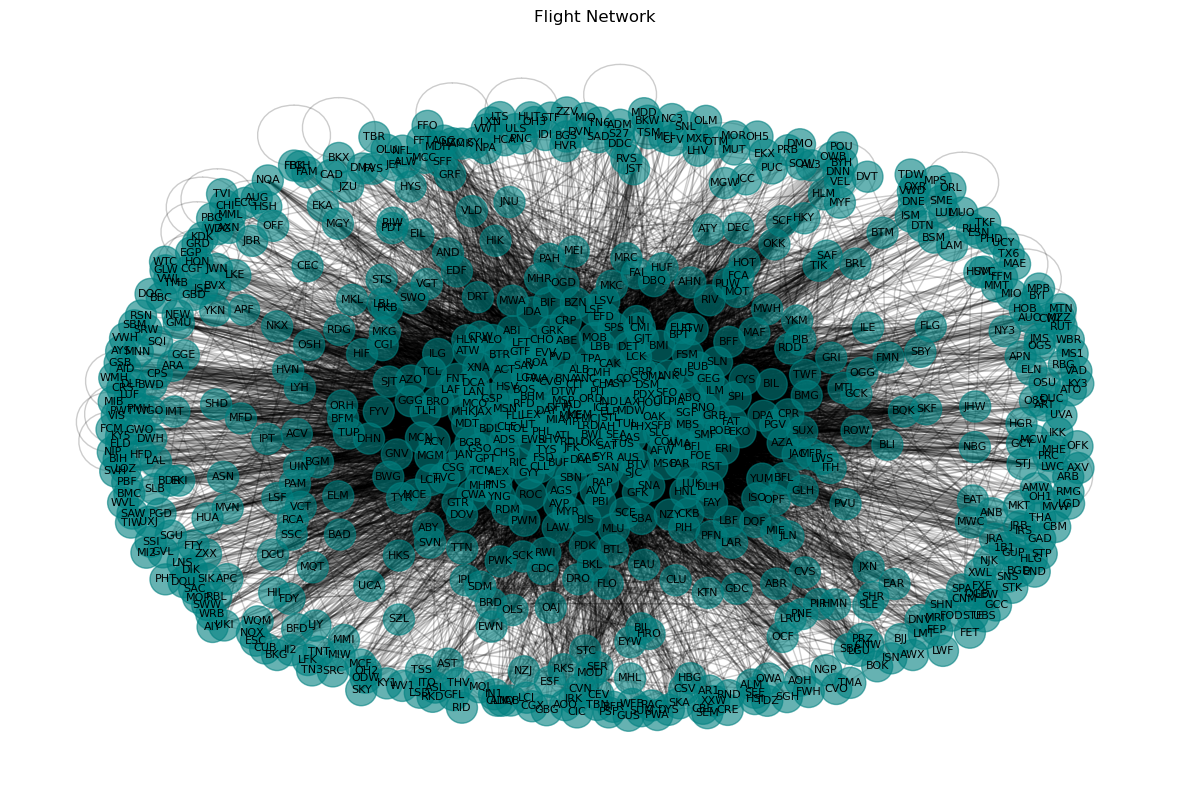

In [5]:
flight_network_undirected = shortest_path.create_undirected_flight_network(working_df)
print("Plotting the undirected flight network")
# visualize the undirected graph
shortest_path.visualize_network(flight_network_undirected, 'Flight Network')

Now, we will find the minimum cut using the Stoer-Wagner algorithm, find the edges crossing the cut, print the edges and their quantity, and displaying the graph having those edges removed!

In [5]:
help(shortest_path.stoer_wagner_min_cut)

Help on function stoer_wagner_min_cut in module shortest_path:

stoer_wagner_min_cut(G)
    Computes the minimum cut using Stoer-Wagner algorithm. It makes use of the following helper functions:
    - minimum_cut_phase: Implements one phase of the Stoer-Wagner algorithm.
    - merge_vertices: Merges vertex v into vertex u.

    Args:
        G (nx.Graph): The input graph
    Returns:
        tuple: (min_cut_value, partition)
            min_cut_value: The minimum cut value - an int
            partition: The partition with the minimum cut - a list of nodes in one partition



In [7]:
help(shortest_path.get_cut_edges)

Help on function get_cut_edges in module shortest_path:

get_cut_edges(G, partition)
    Finds edges crossing the cut.

    Args:
        G (nx.Graph): The input graph
        partition (list): List of nodes in one partition
    Returns:
        list: Edges crossing the cut



Finding the minimum cut using the Stoer-Wagner algorithm
Number of edges crossing the cut / Minimum Number of flights to remove: 1
Edges crossing the cut:
YIP <-> PHD
Plotting the flight network with the cut edges removed


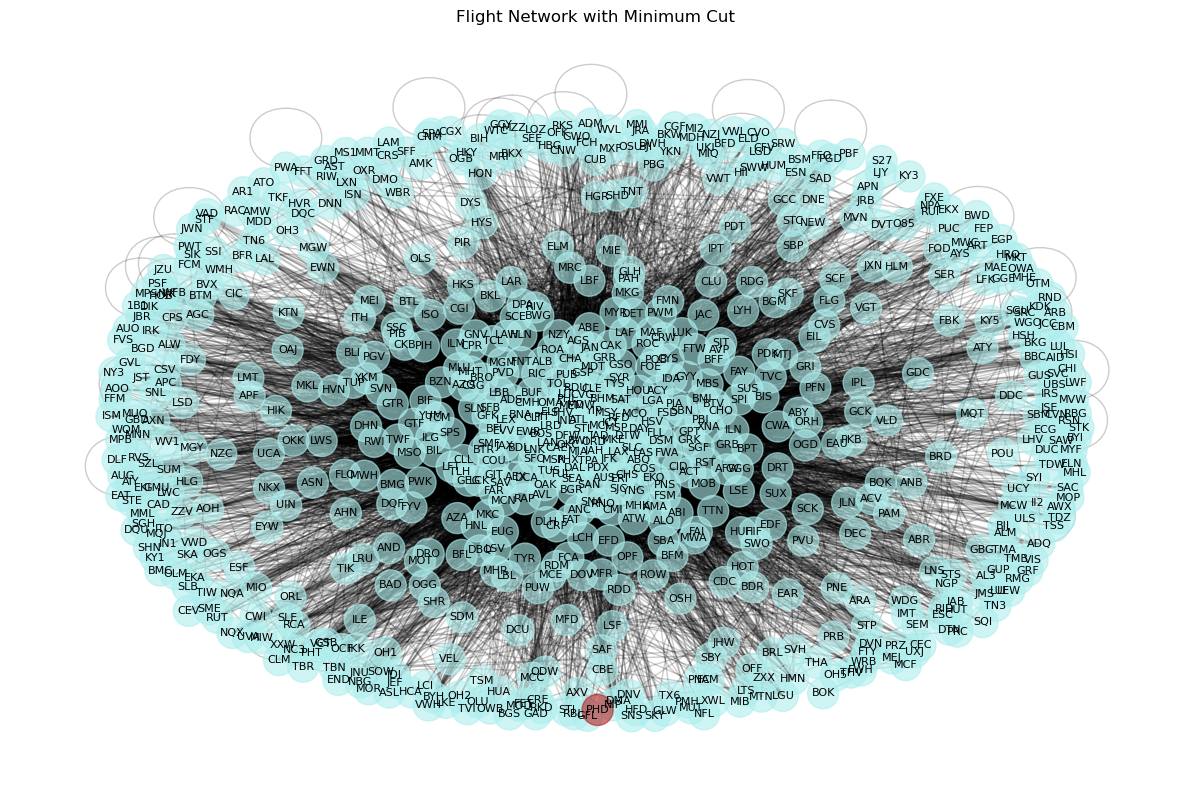

In [7]:
print("Finding the minimum cut using the Stoer-Wagner algorithm")
min_cut_value, min_cut_partition = shortest_path.stoer_wagner_min_cut(flight_network_undirected)

# Find the edges crossing the cut, that is, the edges connecting the two partitions
cut_edges = shortest_path.get_cut_edges(flight_network_undirected, min_cut_partition)

# Explicity print the number of edges crossing the cut and also the edges crossing the cut
print(f"Number of edges crossing the cut / Minimum Number of flights to remove: {len(cut_edges)}")
print("Edges crossing the cut:")
for u,v in cut_edges:
    print(f"{u} <-> {v}")

# Make a copy of the original graph so that we can remove the cut edges and then plot the graph
G_copy = flight_network_undirected.copy()

# Remove the cut edges
G_copy.remove_edges_from(cut_edges)

print("Plotting the flight network with the cut edges removed")
# Visualize the graph with the cut edges removed
shortest_path.visualize_network(G_copy, 'Flight Network with Minimum Cut', min_cut_partition)

Because the question requires us to use a single function for this, we have made use of `disconnect_graph` function that takes as input an undirected graph and outputs the edges (flights) removed. It also plots the two graphs, one with all the edges and one with all the min-cut edges removed. 

In [8]:
help(shortest_path.disconnect_graph)

Help on function disconnect_graph in module shortest_path:

disconnect_graph(G)
    Disconnects the graph into two separate components by removing a minimum number of flights. Makes use of the following helper functions:
    - stoer_wagner_min_cut: Computes the minimum cut using Stoer-Wagner algorithm.
    - get_cut_edges: Finds edges crossing the cut.
    - visualize_network: Visualizes the flight network.

    Args:
        G (nx.Graph): An undirected graph containing flight data
    Returns:
        cut_edges: A list of edges that, if removed, would disconnect the graph into two separate components.



Visualizing original network...


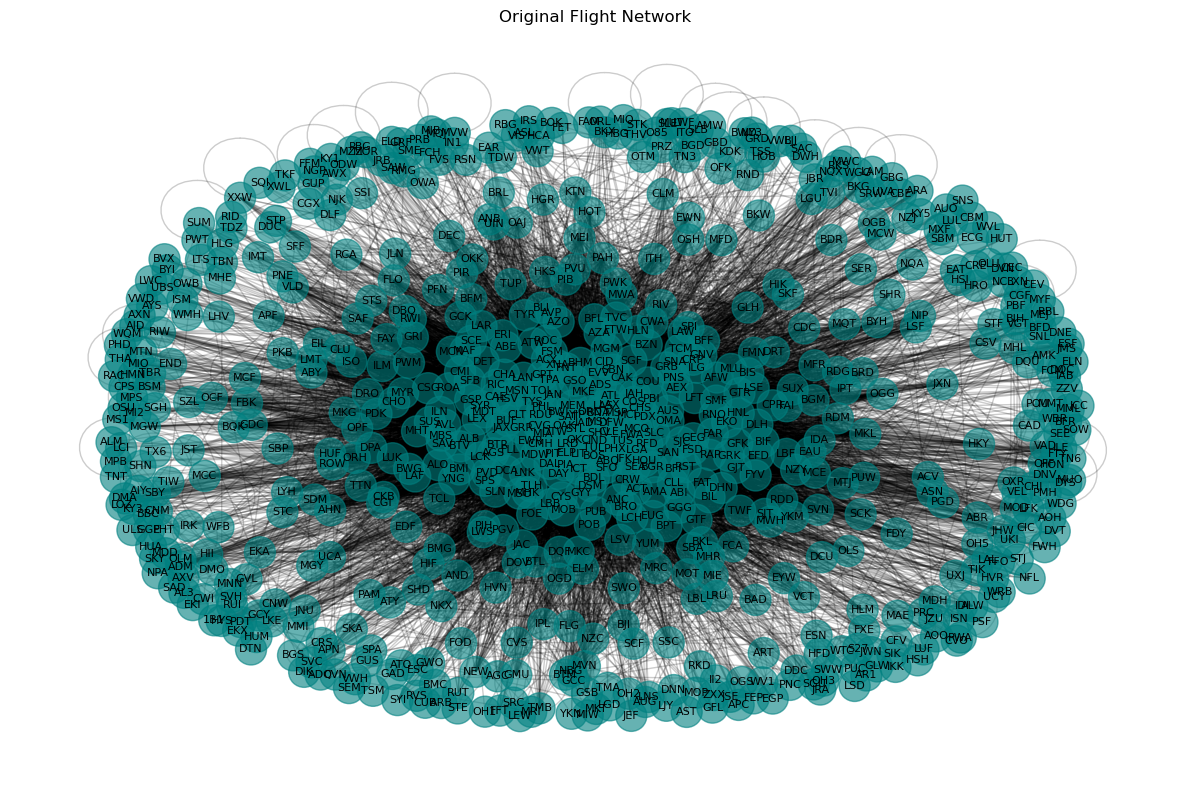

Finding minimum cut...

Minimum number of flights to remove: 1

Flights to remove:
YIP <-> PHD

Visualizing partitioned network...


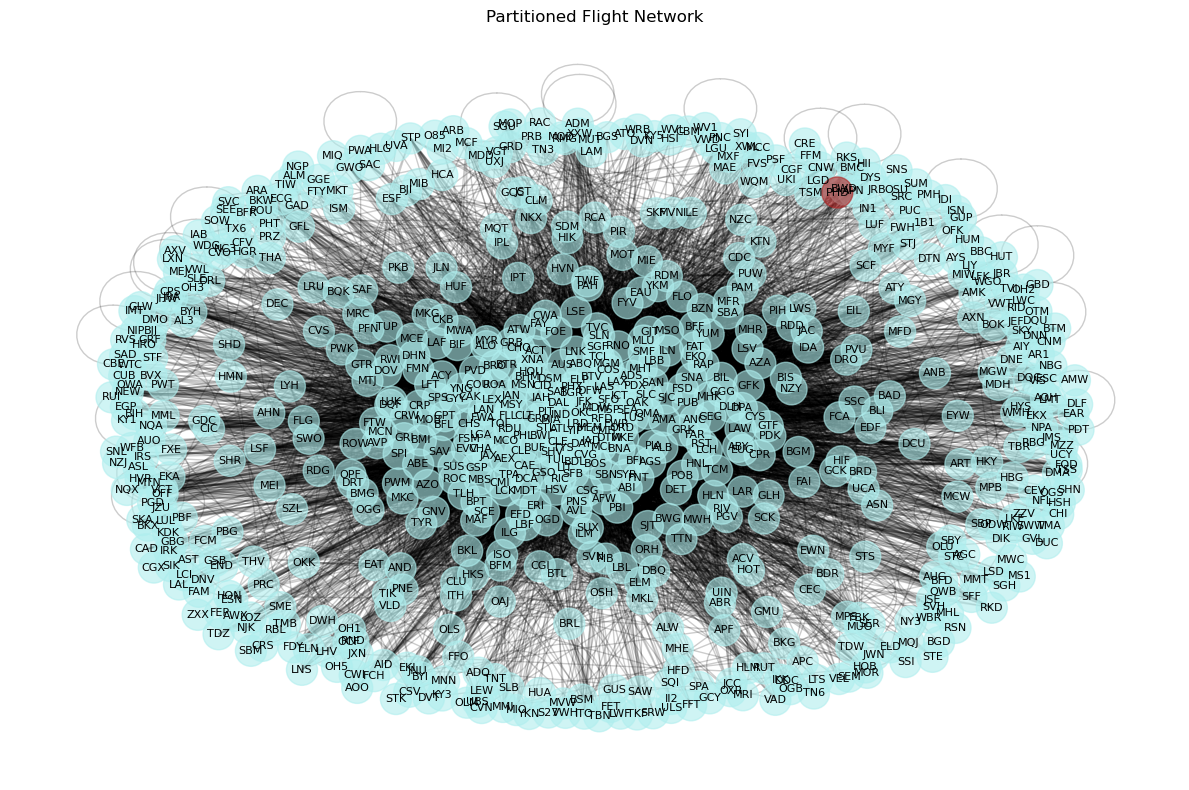

In [6]:
edges_removed = shortest_path.disconnect_graph(flight_network_undirected)

Now because, our graph is sparse, it is really hard to see if the graph is actually disconnected. To show that the algorithm works as intended, we can make use of a dummy network graph and show that it works!

100%|██████████| 14/14 [00:00<00:00, 121826.26it/s]

Visualizing original network...


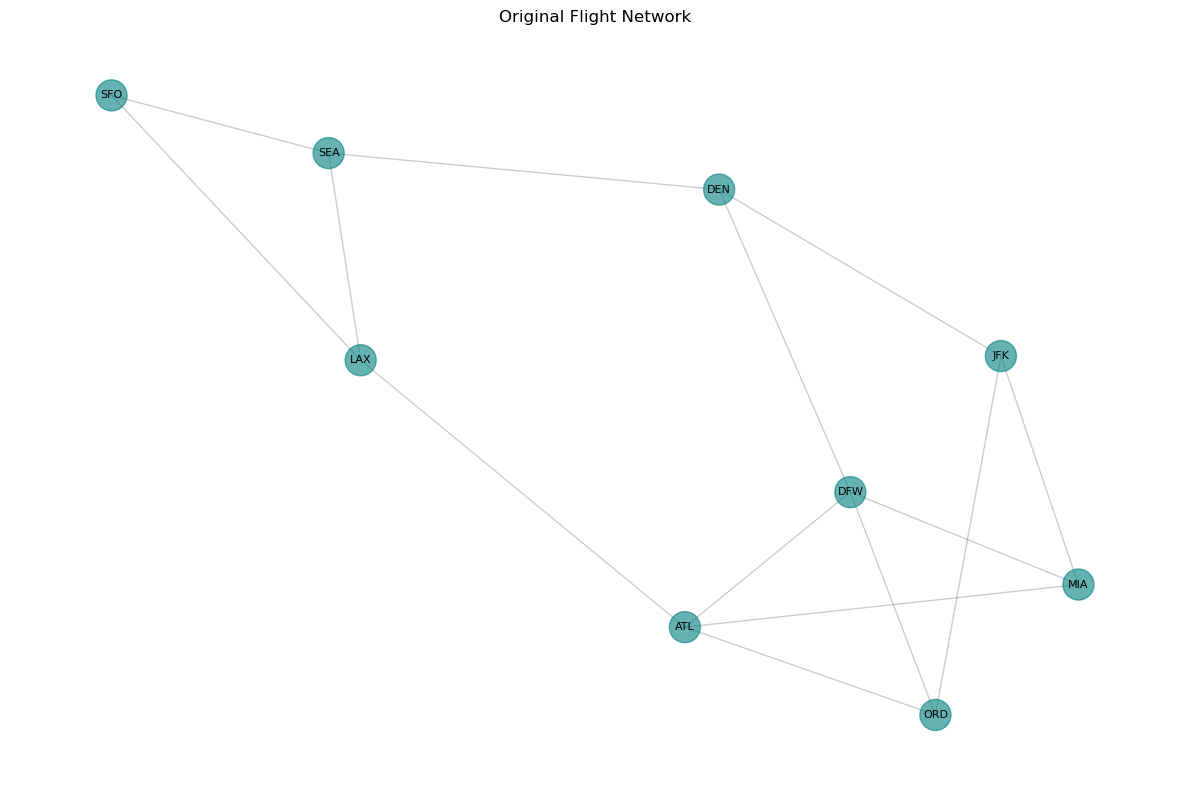

Finding minimum cut...

Minimum number of flights to remove: 2

Flights to remove:
LAX <-> SFO
SFO <-> SEA

Visualizing partitioned network...


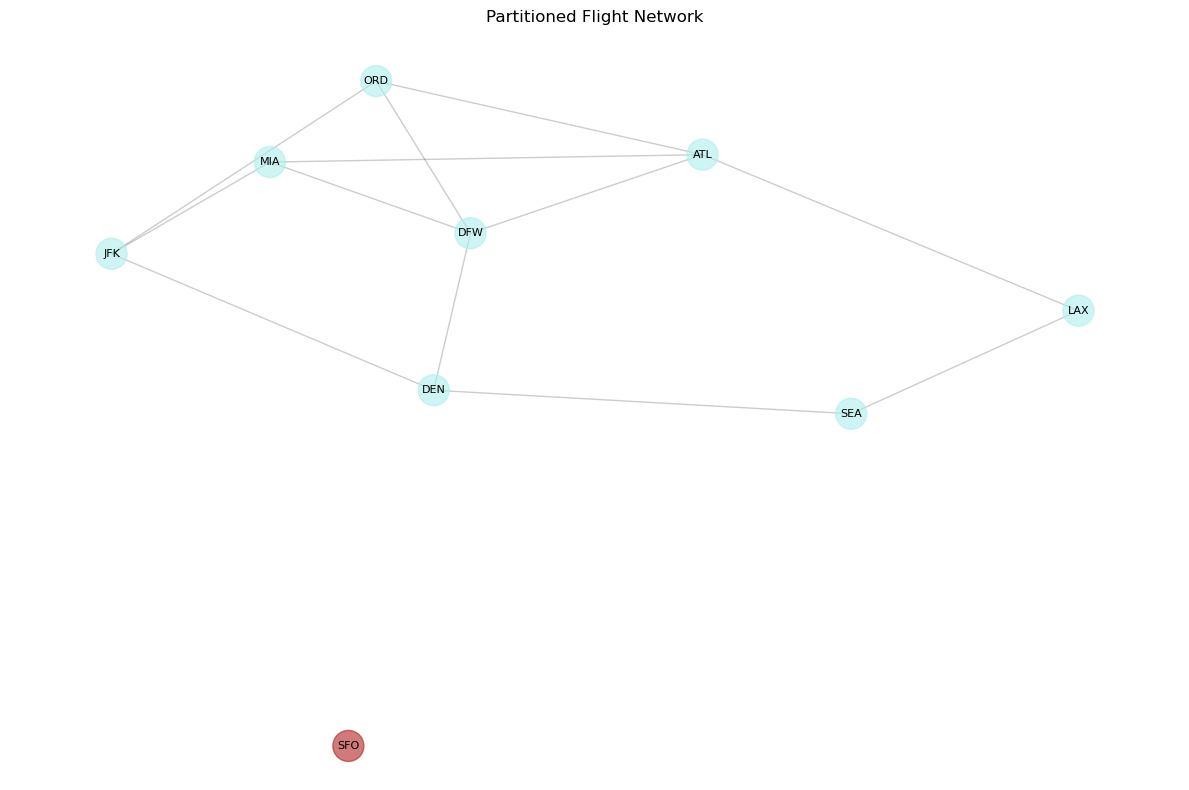

Flights Removed: LAX <-> SFO
Flights Removed: SFO <-> SEA


In [10]:
import networkx as nx
# Create a graph with at least 10 nodes and multiple edges
G = nx.Graph()
edges = [
    ("ATL", "LAX"),
    ("ATL", "ORD"),
    ("ATL", "DFW"),
    ("LAX", "SFO"),
    ("LAX", "SEA"),
    ("ORD", "DFW"),
    ("ORD", "JFK"),
    ("DFW", "DEN"),
    ("DFW", "MIA"),
    ("SFO", "SEA"),
    ("SEA", "DEN"),
    ("DEN", "JFK"),
    ("JFK", "MIA"),
    ("MIA", "ATL")
]

# Add edges to the graph
G.add_edges_from(edges)

# Create a DataFrame from the edges
dummy_df = pd.DataFrame(edges, columns=["Origin_airport", "Destination_airport"])

dummy_flight_network = shortest_path.create_undirected_flight_network(dummy_df)

# run the algorithm

edges_removed = shortest_path.disconnect_graph(dummy_flight_network)
for u, v in edges_removed:
    print(f"Flights Removed: {u} <-> {v}")

As can be seen from the plots, the the graph is correctly disconncted by using the min number of edges!

----